<a href="https://colab.research.google.com/github/LawsonHutter/RNN_working_memory/blob/main/RNN_working_memory_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [5]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [6]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

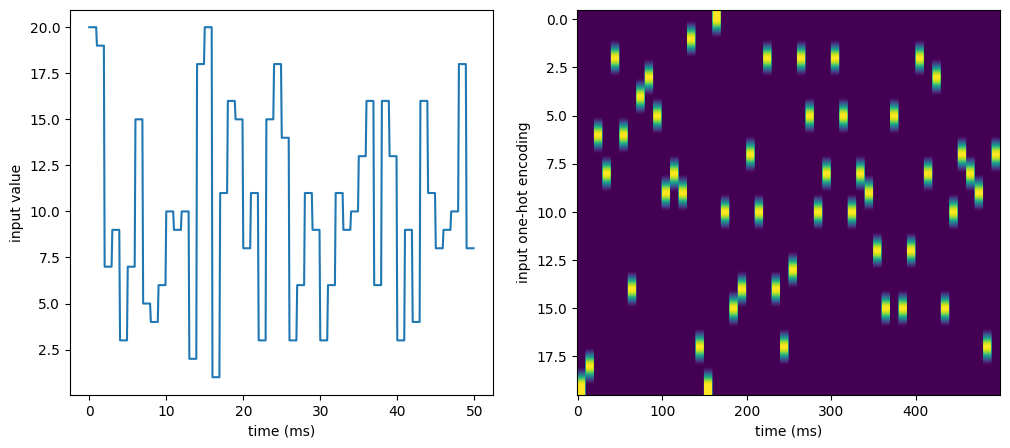

In [7]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

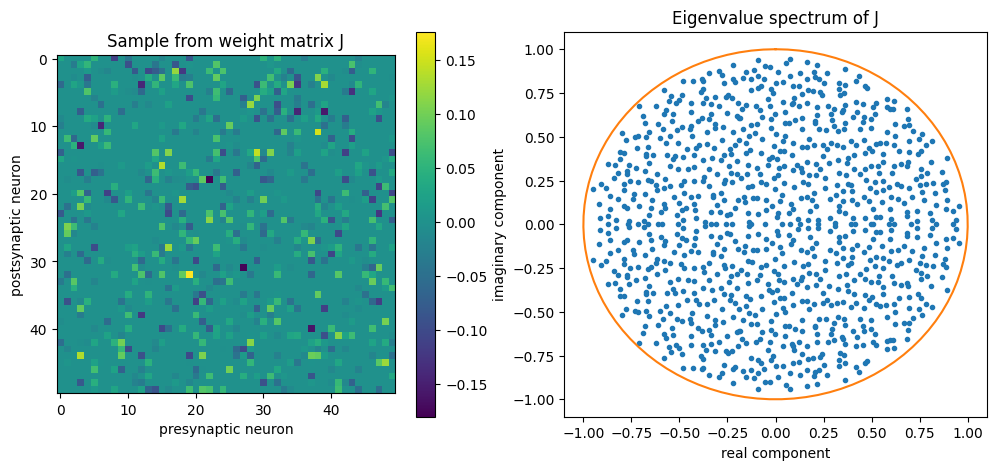

In [8]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

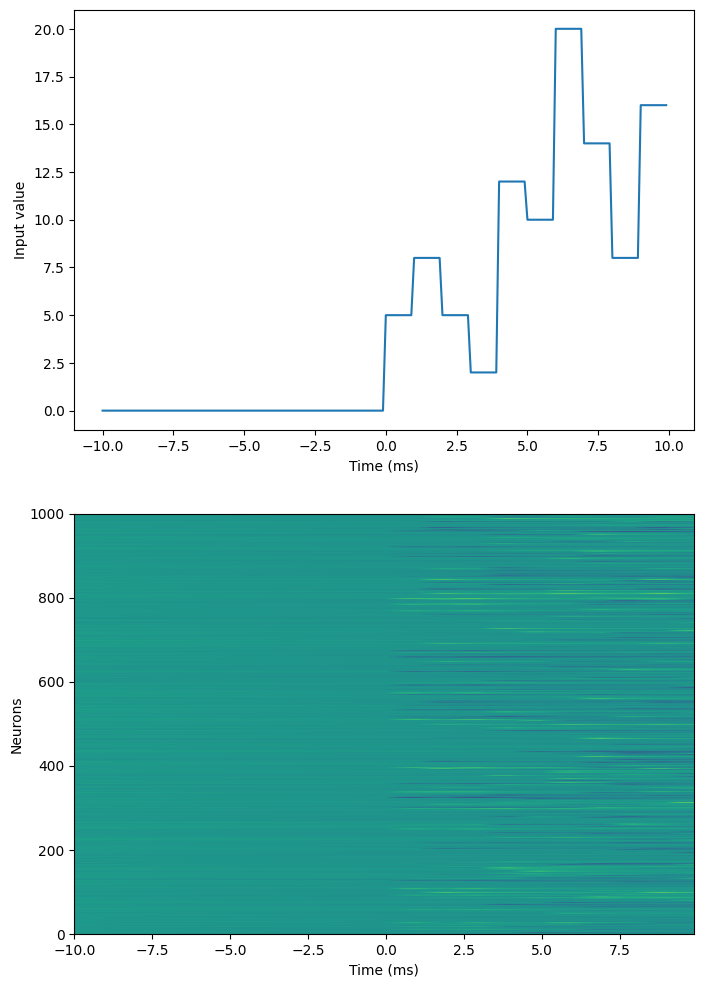

In [9]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

In [23]:
# Our Imports
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K

In [11]:
# Generate a set of input sequences and corresponding firing rate sequences
sequence_length = 100
onehot, inputs = make_input(sequence_length, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(inputs)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']

In [12]:
print("inputs shape")
print(inputs.shape)

print("firing_rates shape")
print(firing_rates.shape)

print("simulation_time shape")
print(simulation_time.shape)

inputs shape
(1100,)
firing_rates shape
(1000, 1100)
simulation_time shape
(200,)


In [21]:
firing_rates.T.shape

(1100, 1000)

Q1)

In [13]:
# Define the maximum value of X to consider
max_X = 5

In [ ]:
"""
Helper functions:

"""

# Function to allow gain parameter g to relu
def modified_relu(g=1.0):
    def relu(x):
        return K.relu(g * x)
    return relu

In [34]:
# Build Model Here
"""
Assumptions / Decisions:

Using a RNN because that seems to be the nature of this assignment
For a decoder, I am assuming the architecture should be 'many to one'
I am unsure of how to incorporate the g parameter.  I am assuming it means gain

"""

# Some declarations
rates = firing_rates.T
input = inputs
max_X = 5

input_size = 1000 # Firing rates of all neurons
output_size = 1 # 1 scaler value 
g = 1 # gain parameter from assignment

# Define an RNN model with a single LSTM layer
model = keras.models.Sequential([
    keras.layers.LSTM(units=input_size, input_shape=(rates.shape)),
    keras.layers.Dense(units=output_size, activation="linear")
])

model.layers[-1].set_weights([g * np.ones((input_size, output_size)), np.zeros((output_size,))])  # set the output layer weights

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
for x in range(max_X):

    # Create the input and target arrays for the current X value
    X_all = firing_rates[x:time_steps-(max_X-x)]
    y_all = input_data[x:time_steps-(max_X-x)-1]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

    # Append the current training and test sets to the list of sets
    train_sets.append((X_train, y_train))
    test_sets.append((X_test, y_test))

In [56]:
# Generate data

train_sets = []
test_sets = []

for x in range(0, max_X):

    # Create the training and test sets for the current X value
    X_all = []
    Y_all = []

    for t in range(1100 - x):
        # Create the input window by taking the firing rates at time t and the previous W-1 time steps
        X_input = rates[t, :]
        # Create the target by taking the input at time t-X
        y_target = input[t-x]

        X_all.append(X_input)
        Y_all.append(y_target)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

    # Append the current training and test sets to the list of sets
    train_sets.append((X_train, y_train))
    test_sets.append((X_test, y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

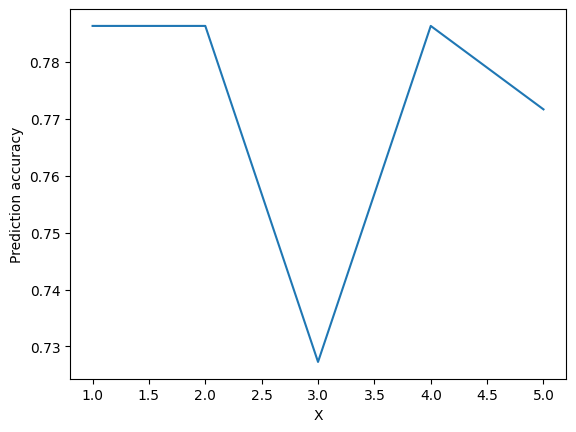

In [48]:
# Define the number of neurons and input sequence length
N = firing_rates.shape[0]
seq_len = inputs.shape[0]

# Train and evaluate a separate decoder for each value of X
accuracies = []

for X in range(1, max_X+1):
    # Create the training set for this value of X
    X_indices = np.arange(X, seq_len)
    X_minus_indices = np.arange(X-1, seq_len-1)
    X_minus_firing_rates = firing_rates[:, X_minus_indices]
    X_inputs = inputs[X_indices]

    # Train the decoder on the training set
    X_train, X_val, y_train, y_val = train_test_split(X_minus_firing_rates.T, X_inputs, test_size=0.2, random_state=42)
    decoder_model.fit(X_train, y_train)

    # Evaluate the decoder on the validation set
    y_pred = decoder_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

# Plot the performance of each decoder as a function of X
plt.plot(range(1, max_X+1), accuracies)
plt.xlabel('X')
plt.ylabel('Prediction accuracy')
plt.show()